In [215]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download Yahoo Data (5 minute interval)

In [216]:
import YahooStocks

tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = YahooStocks.Stocks(tix)
# Download Yahoo and transform
stocks.get_data(interval = '5m')
stocks.transform_data()
# Write to transformed data to SQL
stocks.insert_SQL()
# Read from SQL
stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed


In [217]:
stocks.transformed_data.to_csv('data/mydata.csv')

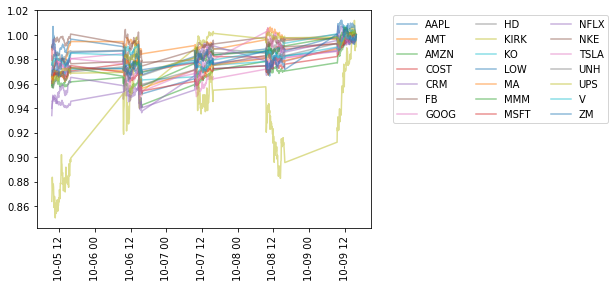

In [218]:
stocks.plot_raw(scale = -1)

# Model

In [219]:
# Prepare Data
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'DateTime')['price']
# Normalize by Last Value
data = data/data.iloc[-1]
data.index = pd.DatetimeIndex(data.index).to_period('M')

# Out of Sample Validation (MASE)

In [228]:
# Q statistic for denominator of MASE
Q = np.mean(np.abs(data.diff().dropna()).mean())
MASE = []
lags = 100
# Rolling origin point forecast
for n in range((2*lags),(data.shape[0] - 1)):
    M = YahooStocks.Model(data=data.iloc[0:n])
    M.fitVAR(lags)
    M.forecast(1)
    MAE = np.abs((data.iloc[n].values - M.fcast.values)[0])
    MASE.append(np.mean(MAE/Q))

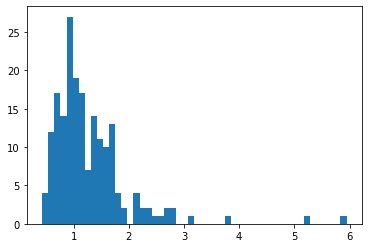

In [229]:
plt.hist(MASE, bins = 50)
plt.show()

In [230]:
np.mean(MASE)

1.2788080901813066

# Forecast

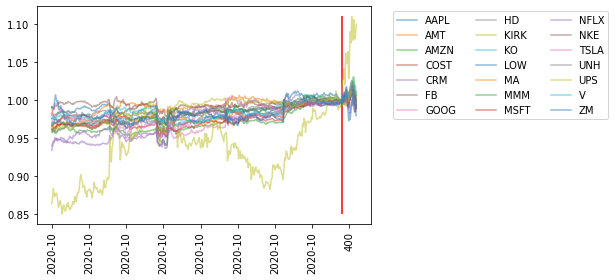

In [227]:
M = YahooStocks.Model(data=data)
M.fitVAR(20)
M.forecast(20)
M.plot_fcast()